# A minimal plot example
By Florian Zemian, May 2025

This example uses a `catalog` to load data that is stored online. The data is loaded, turned into a dataset, and then plotted with the healpix library. Some other plots are also illustrated. 

### Load Packages
We need basic packages, intake (for catalogs) and healpix 
Make sure you have the hackathon environment installed

In [16]:
import intake
from easygems import healpix as egh

import matplotlib.pyplot as plt

### Load the catalog
The magic here is to have a catalog with several different collections of data

There is one collection for each node, which only works at that node, plus the `online` data collection

In [17]:
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")
list (cat)

['EU', 'NERSC', 'NCAR', 'online']

### List Catalog
list the sources in the online catalog, either syntax works

In [18]:
list (cat["online"])
#list(cat.online)

['ERA5',
 'JRA3Q',
 'MERRA2',
 'icon_d3hp003',
 'icon_ngc4008',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3']

### Pick a Data Set
Use .describe() on a dateset to see the other parameter options

In [19]:
#This is messy, but you can see the parameters are method, time, zoom)
#cat.online.icon_d3hp003.describe()

### Load Data into a Data Set
most datasets have a zoom parameter. We will use zoom level 7 (~50km)

In [20]:
ds = cat["online.icon_d3hp003"](zoom=7).to_dask() 
ds

/global/homes/a/agett/.conda/envs/hk25env/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 85GB
Dimensions:       (crs: 1, time: 425, cell: 196608, pressure: 30,
                   pressure_rva: 3)
Coordinates:
  * crs           (crs) float32 4B nan
  * pressure      (pressure) int64 240B 5 10 20 50 ... 92500 95000 97500 100000
  * pressure_rva  (pressure_rva) int64 24B 16 18 23
  * time          (time) datetime64[ns] 3kB 2020-01-02 2020-01-03 ... 2021-03-01
Dimensions without coordinates: cell
Data variables: (12/23)
    egpvi         (time, cell) float32 334MB ...
    einvi         (time, cell) float32 334MB ...
    ekhvi         (time, cell) float32 334MB ...
    ekvvi         (time, cell) float32 334MB ...
    hur           (time, pressure, cell) float32 10GB ...
    hus           (time, pressure, cell) float32 10GB ...
    ...            ...
    ua            (time, pressure, cell) float32 10GB ...
    uas           (time, cell) float32 334MB ...
    va            (time, pressure, cell) float32 10GB ...
    vas           (time, cell) float32 334MB ...
    wa            (time, pressure, cell) float32 10GB ...
    zg            (time, pressure, cell) float32 10GB ...

### Plot data on a map

<Figure size 640x480 with 0 Axes>

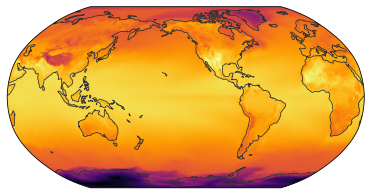

In [21]:
egh.healpix_show(ds["ts"].sel(time="2020-05-10T00:00:00"), cmap="inferno", dpi=72)

### Plot a Zonal Mean or Global Timeseries

Best to do this at lower resolution to reduce data volumes

/global/homes/a/agett/.conda/envs/hk25env/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


Text(0.5, 1.0, 'Zonal Mean ts')

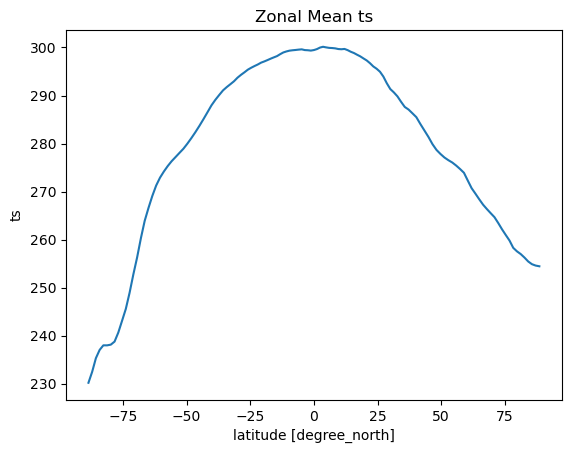

In [25]:
ds = cat["online.icon_d3hp003"](zoom=5).to_dask() 
# This is necessary to know the latitude and longitude of each cell
ds=ds.pipe(egh.attach_coords)

var="ts"

zm = (
    ds[var]
    .groupby("lat")
    .mean()
).compute()

zm.mean(dim='time').plot()
plt.title("Zonal Mean "+var)

### Hovmuller Plot
A similar logic can bin by longitudes over a range of latitudes to make a hovemuller plot in time....

In [27]:
var="rlut"
Slim, Nlim = 15.0, 35.0
da_by_lon = (
    ds[var]
    .where((ds["lat"] > Slim) & (ds["lat"] < Nlim),drop=True)
    .groupby("lon")
    .mean()
).compute()

Now Plot...

Text(0.5, 1.0, 'rlut 15.0 to 35.0')

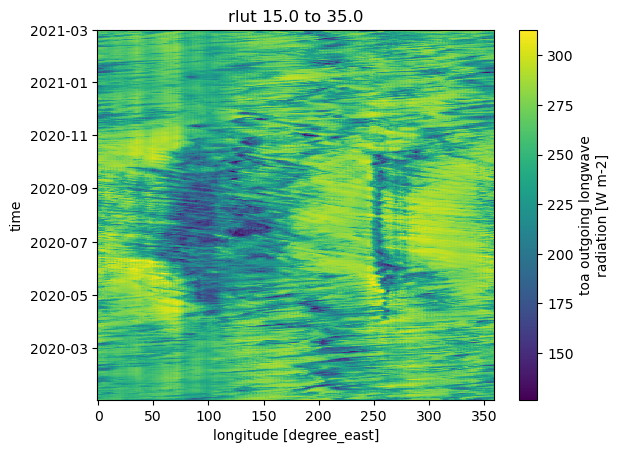

In [47]:
da_by_lon.plot()

latstr=f"{Slim}"+" to "+f"{Nlim}"
plt.title(var+" "+latstr)